## Start by importing the linear model and check the RMSLE:

In [30]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

import statsmodels.api as sm

#Load our two Data Frames
AmesDummies = pd.read_csv('AmesDummies.csv')
AmesDummiesOrdinal = pd.read_csv('AmesDummiesOrdinal.csv')

In [31]:
#Load the Forward Selection DF, which contains the list of Features to include in the linear model:
AmesFeatureDF = pd.read_csv('AmesDummiesForwardAICList.csv')

In [32]:
#Trim AmesDummiesOrdinal to a DF containing only the selected Features:
AmesDF = pd.concat([AmesDummiesOrdinal[list(AmesFeatureDF['CreatedFeatures'])],AmesDummiesOrdinal[['SalePrice']]], axis=1)
AmesDF.shape

(1458, 65)

In [33]:
#Transform AmesDF into the Train AmesDF
np.random.seed(19)
testIdxes = np.random.choice(range(1458), size=292, replace=False)
trainIdxes = list(set(range(1458))-set(testIdxes))

AmesDF2 = AmesDF.copy()
AmesDF = AmesDF.iloc[trainIdxes,]
AmesDFTest = AmesDF2.iloc[testIdxes,]

In [34]:
#Reindex the AmesDF:
AmesDF.index = range(1166)

In [35]:
#Run Linear Regression on the Overall (80%) train set, based on earlier K-fold:

#Create X and Y variables
X = AmesDF.drop('SalePrice', axis=1)
Y = AmesDF['SalePrice']

#Rename the true (20% untouched) test DFs
testX = AmesDFTest.drop('SalePrice', axis=1)
testY = AmesDFTest['SalePrice']

#Run the linear regression and check RMSLE:
lm.fit(X, Y)
lmscore = lm.score(X, Y)
lmpredict = lm.predict(X)

#Get scores for the Test set
lmtestscore = lm.score(testX, testY)
testpredict = lm.predict(testX)

RMSLE = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredict), 2)))

print("The train R^2 score is: " + str(lmscore))
print("The test R^2 score is: " + str(lmtestscore))
print("The test RMSLE is: " + str(RMSLE))


The train R^2 score is: 0.9158717409105691
The test R^2 score is: 0.889040142654703
The test RMSLE is: 0.14516668513609218


## Now, import the Random Forest model and check the overall RMSLE:

In [36]:
#Run Random Forest on the Overall (80%) train set, based on earlier K-fold:


#Import RandomForestRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
randomForest = ensemble.RandomForestRegressor()
randomForest.set_params(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, 
                        n_estimators=200)

#Run the linear regression and check RMSLE:
randomForest.fit(X, Y)
rfscore = randomForest.score(X, Y)
rfpredict = randomForest.predict(X)

#Get scores for the Test set
rftestscore = randomForest.score(testX, testY)
testpredictrf = randomForest.predict(testX)

RMSLErf = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictrf), 2)))

print("The train R^2 score is: " + str(rfscore))
print("The test R^2 score is: " + str(rftestscore))
print("The test RMSLE is: " + str(RMSLErf))

The train R^2 score is: 0.9999964060537203
The test R^2 score is: 0.9013516571083012
The test RMSLE is: 0.13443814302991808


## Now, import the Gradient Boost model and check the overall RMSLE:

In [37]:
#Run Gradient Boost on the Overall (80%) train set, based on earlier K-fold:

#Import GradientBoostRegressor and set parameters to those found in the hyperparameter testing:
from sklearn import ensemble
gradientBoost = ensemble.GradientBoostingRegressor()
gradientBoost.set_params(n_estimators=800, min_samples_split=6, min_samples_leaf=4, max_features='log2', max_depth=2, loss='huber')

#Run the linear regression and check RMSLE:
gradientBoost.fit(X, Y)
gbscore = gradientBoost.score(X, Y)
gbpredict = gradientBoost.predict(X)

#Get scores for the Test set
gbtestscore = gradientBoost.score(testX, testY)
testpredictgb = gradientBoost.predict(testX)

RMSLEgb = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(testpredictgb), 2)))

print("The train R^2 score is: " + str(gbscore))
print("The test R^2 score is: " + str(gbtestscore))
print("The test RMSLE is: " + str(RMSLEgb))

The train R^2 score is: 0.9709359823757673
The test R^2 score is: 0.9183626743430598
The test RMSLE is: 0.12319397381050928


## Combine (stack) these results to generate a prediction for SalePrice and see if it outperforms the gradient boosting prediction

In [38]:
stackedpredict = (gradientBoost.predict(testX) + randomForest.predict(testX) + lm.predict(testX))/3
RMSLEstacked = np.sqrt(np.mean(np.power(np.log1p(testY)-np.log1p(stackedpredict), 2)))
print("The stacked-model RMSLE is: " + str(RMSLEstacked))

The stacked-model RMSLE is: 0.11835903305464814


In [17]:
#Wow!

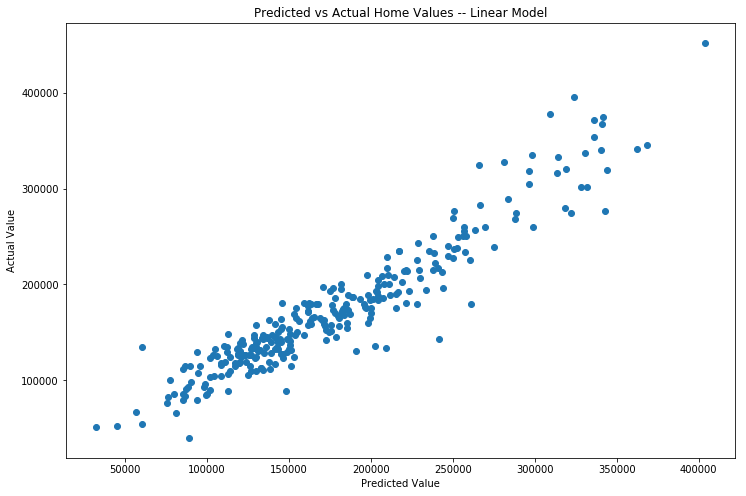

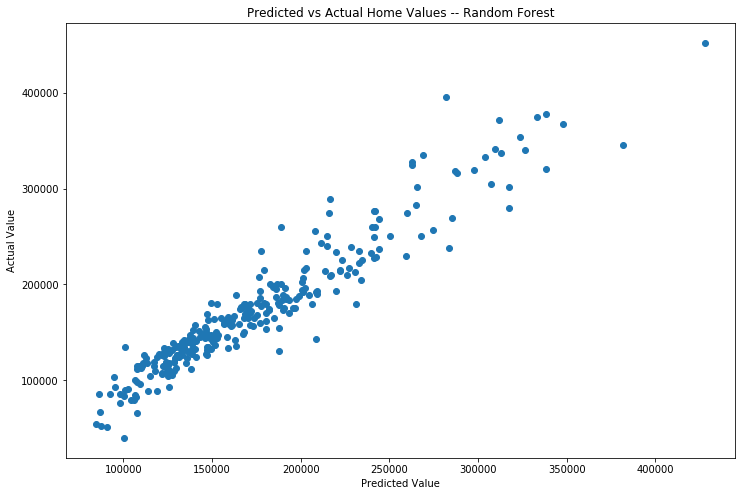

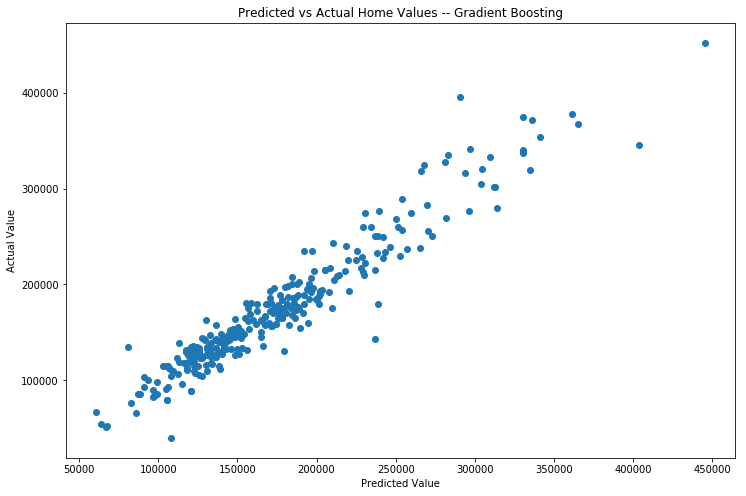

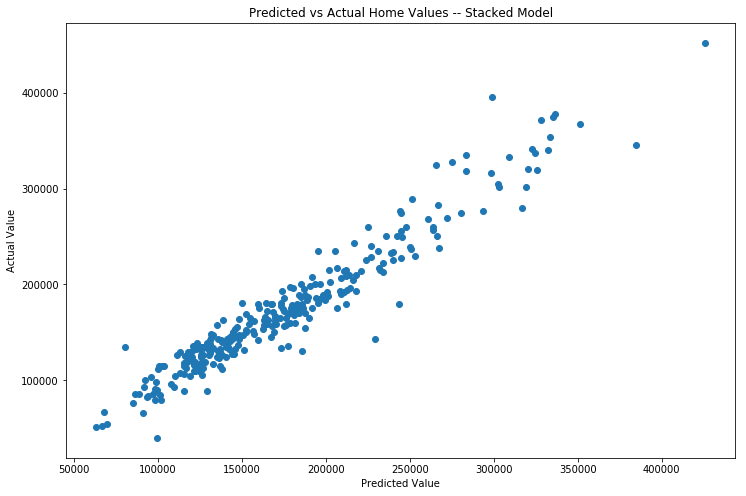

In [39]:
import matplotlib.pyplot as plt

for tup in [('Linear Model', testpredict), ('Random Forest', testpredictrf), ('Gradient Boosting', testpredictgb), ('Stacked Model', stackedpredict)]:

    plt.figure(figsize=(12,8))
    plt.scatter(tup[1], testY)
    plt.xlabel('Predicted Value')
    plt.ylabel('Actual Value')
    plt.title('Predicted vs Actual Home Values -- ' + tup[0])   
    plt.show()